In [0]:
#@title Copyright 2020 TensorFlow Constrained Optimization Authors. Double-Click Here for License Information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Constrained Optimization Example Using CelebA Dataset
Building on other [TensorFlow Constrained Optimization (TFCO)](https://github.com/google-research/tensorflow_constrained_optimization/tree/master/README.md) examples, the purpose of this notebook is to further demonstrate how easy it is to create and optimized constrained problems using the TFCO library. In particular, this notebook will:


*   Train a simple, *unconstrained* neural network model to detect a person's smile in images using [`tf.keras`](https://www.tensorflow.org/guide/keras) and the large-scale CelebFaces Attributes ([CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)) dataset.
*   Evaluate model performance across age group.
*   Set up a simple constrained optimization problem to achieve fairer perforamnce across age group.
*   Retrained the now *constrained* model and evaluate performance again.

Last updated: 17 Feb 2020





# Installation
This notebook was created in [Colaboratory](https://research.google.com/colaboratory/faq.html), connected to the Python 3 Google Compute Engine backend. If you wish to host this notebook in a different environment, then you should not experience any major issues so long as you include all the required packages listed in the cell below.

Also, depending on when you run the cell below, you may receive a warning about the default version of TensorFlow in Colab switching to TensorFlow 2.X soon. You can safely ignore that warning as this notebook was designed to be compatible with TensorFlow 1.X and 2.X.

In [0]:
#@title Import Modules
!pip install -q tensorflow-datasets tensorflow numpy pandas matplotlib seaborn
import os
import sys
import tempfile
import urllib3

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
import tensorflow_constrained_optimization as tfco

Though TFCO is compatible with eager and graph execution, this notebook assumes that eager execution is enabled by default. To ensure that nothing breaks, eager execution will be enabled in the cell below.

In [3]:
#@title Enable Eager Execution
if tf.__version__ < "2.0.0":
  tf.enable_eager_execution()
  print("Eager execution enabled.")
else:
  print("Eager execution enabled by default.")

print("TensorFlow " + tf.__version__)

Eager execution enabled.
TensorFlow 1.15.0


# CelebA Dataset
[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200,000 celebrity images, each with 40 attribute annotations (such as hair type, fashion accessories, facial features, etc.) and 5 landmark locations (eyes, mouth and nose positions). CelebA is readily made available in TensorFlow thanks to [TensorFlow Datasets(`tfds`)](https://www.tensorflow.org/datasets), which is where and how this notebook will download and extract the dataset.

Specifically, in this notebook:
*   The "Smiling" attribute — which presumably represents a pleased, kind or amused expression in the image with the corners of the mouth turned up and front teeth possibly exposed — will be set as the target variable for the model to predict.
*   Images will be resized from 218x178 to 28x28 to reduce the amount of execution time and memory when training.
*   Performance will be evaluated across the "Young" attribute, which will be dubbed "age group" in this notebook.




### Possible Checksum Error
On rare occasions, running the cell below may return a `NonMatchingChecksumError` message. As [reported elsewhere](https://github.com/tensorflow/datasets/issues/943), this error message might be due to an incomplete download. CelebA is rather large and can sometimes fail to download. So this may be a Google Drive issue rather than TFDS.

In our experiences, running the cell again at a later point in time will resolve that error and allow you to download the dataset.

In [0]:
celeb_a_builder = tfds.builder("celeb_a")
celeb_a_builder.download_and_prepare()

## Caveats
Before moving forward, there are several considerations to keep in mind in using CelebA:
*   Though in principle this notebook could use any dataset of face images, CelebA was chosen because it contains public domain images of public figures, which avoids certain policy and privacy issues of some other public domain datasets.
*   All of the attribute annotations in CelebA come operationalized as binary categories. For example, the "Young" attribute, which loosely and presumably represents perceived behavior or appearance of young people, is denoted as either present or absent in the image. In other words, the absence of "Young" in an image does not always imply that the image features an "Old" celebrity.
*   CelebA's categorizations do not reflect real human diversity of attributes.
*   For the purposes of this notebook, the "Young" attribute is dubbed "age group", where the presence of the "Young" attribute in an image is labeled as a member of the "young" age group and the absence of the "Young" attribute is labeled as a member of the "old" age group. These are assumptions made as this information is not mentioned in the [original paper](http://openaccess.thecvf.com/content_iccv_2015/html/Liu_Deep_Learning_Face_ICCV_2015_paper.html).
*   As such, performance in the models trained in this notebook is tied to the ways the attributes have been operationalized and annotated by the authors of CelebA.
*   This model should not be used for commerical purposes as that would voilate CelebA's non-commerical research agreement.

# Setting Up Input and Visualization Functions
Now that CelebA is loaded in as a `tf.data.Dataset` object, the rest of the input pipeline can now be defined for model training. The subsequent cells will help streamline the input pipeline as well as visualize performance.

In [0]:
#@title Define Image Preprocessing and Filtering Functions

ATTR_KEY = "attributes"
IMAGE_KEY = "image"
LABEL_KEY = "Smiling"
GROUP_KEY = "Young"
IMAGE_SIZE = 28
BATCH_SIZE = 1024

def preprocessing_function(feat_dict):
  # Separate out the image and target variable from the feature dictionary.
  image = feat_dict[IMAGE_KEY]
  label = feat_dict[ATTR_KEY][LABEL_KEY]
  group = feat_dict[ATTR_KEY][GROUP_KEY]

  # Resize and normalize image.
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0

  # Cast label and group to float32.
  label = tf.cast(label, tf.float32)
  group = tf.cast(group, tf.float32)

  return image, label, group

# These filtering fuctions will be called after the image preprocessing step to
# evalute performance with respect to groups.
def filter_young_group(image, label, young_group):
  return True if tf.math.equal(young_group, 1.0) else False

def filter_old_group(image, label, young_group):
  return True if tf.math.equal(young_group, 0.0) else False

In [0]:
#@title Define False Positive Rate Calculator
def calculate_fpr(results):
  # results[] is a list of scalars that represent different metrics. In order,
  # it represents the following: loss, accuracy, false positives, true negatives
  fp = results[2]
  tn = results[3]

  fpr = float(fp / (fp + tn))
  return fpr

In [0]:
#@title Define Input Function
def input_function(split, batch_size, subgroup_filter):
  # Use tfds.load method to build and load CelebA.
  celeb_a_data = celeb_a_builder.as_dataset(split=split)

  # Shuffle and batch dataset depending on split.
  if split == 'train':
    celeb_a_data = celeb_a_data.shuffle(1024).repeat().batch(batch_size)
  elif split == 'test':
    celeb_a_data = celeb_a_data.batch(batch_size)

  # Apply preprocessing transformations.
  celeb_a_data = celeb_a_data.map(preprocessing_function)

  # When necessary, filter by age group of interest.
  if subgroup_filter == 'Young':
    celeb_a_data = celeb_a_data.filter(filter_young_group)
  elif subgroup_filter == 'Old':
    celeb_a_data = celeb_a_data.filter(filter_old_group)

  # Return the transformed CelebA set.
  return celeb_a_data

In [0]:
#@title Define Plot Function
def plot_results(results, title):
  # Change default font type.
  rcParams.update({
  'font.family':'sans-serif',
  'font.sans-serif':['Liberation Sans'],
  })

  # Set appropriate context for figure aesthetics.
  sns.set_context("notebook", font_scale=1.5)

  if len(results) == 2:
    # Plot bar charts for unconstrained model performance.
    values = [value * 100 for value in results] # Converts rate to percentage
    group_names = ['Young', 'Old']

    plt.figure(figsize=(6, 3))
    plt.barh(group_names, values, color=["#377eb8", "#ff7f00"])
    plt.xlim([0, int(max(values)) + 2])
    plt.xlabel('False Positive Rate %')
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    plt.title(title)
    plt.show()
  else:
    # Plot bar charts for unconstrained and constrained model performance.
    values = [value * 100 for value in results]
    df = pd.DataFrame(dict(graph=['Unconstrained', 'Constrained'],
                           young=values[::2], old=values[1::2]))
    index = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(index, df.young, width, color="#377eb8", label='Young')
    ax.barh(index + width, df.old, width, color="#ff7f00", label='Old')

    plt.xlim([0, int(max(values)) + 2])
    plt.xlabel('False Positive Rate %')
    ax.set(yticks=index + (width / 2), yticklabels=df.graph)
    ax.legend()

    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    plt.title(title)
    plt.show()

# Build, Train & Evaluate Unconstrained Model
To keep this notebook focused on TFCO, a simple, unconstrained `tf.keras.Sequential` model will be assembled.

It is possible that model performance can greatly be improved upon by adding some complexity (e.g., more densely-connected layers, exploring different activiation functions, increasing image size), but that may distract from the goal of demonstrating how easy it is to apply the TFCO library when working with Keras. For that reason, the model will be kept simple — but feel encouraged to explore this space.

In [0]:
NUM_CLASSES = 2

# For this notebook, accuracy, false positives (FPs) and true negatives (TNs)
# will be used to evaluate performance. With FP and TN, the false positive rate
# can be calculated: FP / (FP + TN)
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn')
]

# The model consists of:
# 1. An input layer that represents the 28x28x3 image flatten.
# 2. A fully connected layer with 64 units activated by a ReLU function.
# 3. A single-unit readout layer to output real-scores instead of probabilities.
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=None)
])

# TFCO by default uses hinge loss — and that will also be used in the model.
model.compile(
    optimizer=tf.train.AdamOptimizer(0.001),
    loss='hinge',
    metrics=METRICS)

With the model now defined and the input pipeline in place, the model is ready for training. To cut back on the amount of execution time and memory, the model will be trained by slicing the data into small batches with a small amount of repeated iterations.

By the way, running this notebook in TensorFlow < 2.0.0 may result in a deprecation warning for `np.where`. Safely ignore this warning as TensorFlow addresses this in 2.X by using `tf.where` in place of `np.where`.

In [28]:
celeb_a_train_data = input_function(
    tfds.Split.TRAIN, batch_size=32, subgroup_filter='None')
model.fit(celeb_a_train_data, epochs=5, steps_per_epoch=1000)

Epoch 1/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.2385 - accuracy: 0.8572 - fp: 1097.0000 - tn: 15468.0000
Epoch 2/5
1000/1000 [==============================] - 40s 40ms/step - loss: 0.2384 - accuracy: 0.8571 - fp: 1065.0000 - tn: 15685.0000
Epoch 3/5
1000/1000 [==============================] - 40s 40ms/step - loss: 0.2370 - accuracy: 0.8576 - fp: 1001.0000 - tn: 15588.0000
Epoch 4/5
1000/1000 [==============================] - 40s 40ms/step - loss: 0.2354 - accuracy: 0.8560 - fp: 1051.0000 - tn: 15685.0000
Epoch 5/5
1000/1000 [==============================] - 41s 41ms/step - loss: 0.2297 - accuracy: 0.8595 - fp: 1021.0000 - tn: 15579.0000


Evaluating the model on the test data should result in a final accuracy score of around 80% to 85%. Not bad for a simple model with no fine tuning.

In [29]:
print('Overall Results, Unconstrained')
celeb_a_test_data = input_function(
    tfds.Split.TEST, batch_size=32, subgroup_filter='None')
results = model.evaluate(celeb_a_test_data)

Overall Results, Unconstrained
    624/Unknown - 25s 40ms/step - loss: 0.2217 - accuracy: 0.8760 - fp: 965.0000 - tn: 9010.0000

However, performance evaluated across age group may reveal some shortcomings.

In [30]:
print('Results for Young Group, Unconstrained')
celeb_a_test_young_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Young')
unconstrained_results_young = model.evaluate(celeb_a_test_young_group_data)

Results for Young Group, Unconstrained
  15114/Unknown - 104s 7ms/step - loss: 0.2929 - accuracy: 0.8857 - fp: 551.0000 - tn: 7066.0000

In [31]:
print('Results for Old Group, Unconstrained')
celeb_a_test_old_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Old')
unconstrained_results_old = model.evaluate(celeb_a_test_old_group_data)

Results for Old Group, Unconstrained
   4848/Unknown - 52s 11ms/step - loss: 0.0000e+00 - accuracy: 0.8457 - fp: 414.0000 - tn: 1944.0000

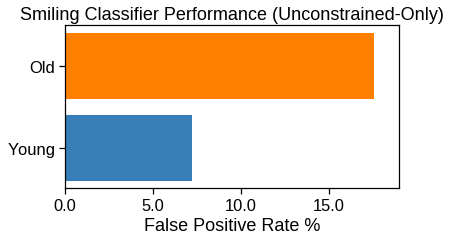

In [32]:
#@title Calculate FPR and Compare Unconstrained Performance
young_fpr_unconstrained = calculate_fpr(unconstrained_results_young)
old_fpr_unconstrained = calculate_fpr(unconstrained_results_old)

title = 'Smiling Classifier Performance (Unconstrained-Only)'
plot_results([young_fpr_unconstrained, old_fpr_unconstrained], title)

A false positive is where the model incorrectly predicts the positive class. In this context, that means a false positive outcome occurs when the ground truth is an image of a celebrity 'Not Smiling' and the model predicts 'Smiling'. By extension, the false positive rate, which is used in the visualization above, is a measure of accuracy for a test.

Looking at performance across age group should reveal a **disproportionate gap between "Old" and "Young" categories**.

This is where TFCO can come in and help close that gap by constraining the false positive rate to be within a more acceptable criterion.


# Constrained Model Set Up
As documented in [TFCO's library](https://github.com/google-research/tensorflow_constrained_optimization/tree/master/README.md), there are severeal helpers that will make it easier to constrain the problem:

1.   `tfco.rate_context()` – This is what will be used in constructing a constraint for each age group category.
2.   `tfco.RateMinimizationProblem()`– The rate expression to be minimized here will be the false positive rate subject to age group. In other words, performance now will be evaluated based on the difference between the false positive rates of the age group and that of the overall dataset. For this demonstration, a false positive rate of less than or equal to 5% will be set as the constraint.
3.   `tfco.ProxyLagrangianOptimizerV2()` – This is the helper that will actually solve the rate constraint problem.

The cell below will call on these helpers to set up model training with the fairness constraint.




In [0]:
# The batch size is needed to create the input, labels and group tensors.
# These tensors are initialized with all 0's. They will eventually be assigned
# the batch content to them. A large batch size is chosen so that there are
# enough number of "Young" and "Old" examples in each batch.
BATCH_SIZE = 1024

# Create input tensor.
input_tensor = tf.Variable(
    np.zeros((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), dtype="float32"),
    name="input")

# Create labels and group tensors (assuming both labels and groups are binary).
labels_tensor = tf.Variable(
    np.zeros(BATCH_SIZE, dtype="float32"), name="labels")
groups_tensor = tf.Variable(
    np.zeros(BATCH_SIZE, dtype="float32"), name="groups")

# Create a function that returns the applied 'model' to the input tensor
# and generates constrained predictions.
def predictions():
  return model(input_tensor)

# Create overall context and subsetted context.
# The subsetted context contains subset of examples where group attribute < 1
# (i.e. the subset of "Old" celebrity images).
# "groups_tensor < 1" is used instead of "groups_tensor == 0" as the former
# would be a comparison on the tensor value, while the latter would be a
# comparison on the Tensor object.
context = tfco.rate_context(predictions, labels=lambda:labels_tensor)
context_subset = context.subset(lambda:groups_tensor < 1)

# Setup list of constraints.
# In this notebook, the constraint will just be: FPR to less or equal to 5%.
constraints = [tfco.false_positive_rate(context_subset) <= 0.05]

# Setup rate minimization problem: minimize overall error rate s.t. constraints.
problem = tfco.RateMinimizationProblem(tfco.error_rate(context), constraints)

# Create constrained optimizer and obtain train_op.
# Separate optimizers are specified for the objective and constraints
optimizer = tfco.ProxyLagrangianOptimizerV2(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      constraint_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      num_constraints=problem.num_constraints)

# A list of all trainable variables is also needed to use TFCO.
var_list = (model.trainable_weights + problem.trainable_variables +
            optimizer.trainable_variables())

The model is now set up and ready to be trained with the false positive rate constraint across age group.

Now, because the last iteration of the constrained model may not necessarily be the best performing model in terms of the defined constraint, the TFCO library comes equipped with `tfco.find_best_candidate_index()` that can help choose the best iterate out of the ones found after each epoch. Think of `tfco.find_best_candidate_index()` as an added heuristic that ranks each of the outcomes based on accuracy and fairness constraint (in this case, false positive rate across age group) separately with respect to the training data. That way, it can search for a better trade-off between overall accuracy and the fairness constraint.

The following cells will start the training with constraints while also finding the best performing model per iteration.

In [33]:
# Obtain train set batches.
celeb_a_train_data = input_function(
    tfds.Split.TRAIN, batch_size=BATCH_SIZE, subgroup_filter='None')

NUM_ITERATIONS = 1000  # Number of training iterations.
SKIP_ITERATIONS = 10  # Print training stats once in this many iterations.

# Create temp directory for saving snapshots of models.
temp_directory = tempfile.mktemp()
os.mkdir(temp_directory)

# List of objective and constraints across iterations.
objective_list = []
violations_list = []

# Training iterations.
iteration_count = 0
for (image, label, group) in celeb_a_train_data:
  # Assign current batch to input, labels and groups tensors.
  input_tensor.assign(image)
  labels_tensor.assign(label)
  groups_tensor.assign(group)

  # Run gradient update.
  optimizer.minimize(problem, var_list=var_list)

  # Record objective and violations.
  objective = problem.objective()
  violations = problem.constraints()

  sys.stdout.write(
      "\r Iteration %d: Hinge Loss = %.3f, Max. Constraint Violation = %.3f"
      % (iteration_count + 1, objective, max(violations)))

  # Snapshot model once in SKIP_ITERATIONS iterations.
  if iteration_count % SKIP_ITERATIONS == 0:
    objective_list.append(objective)
    violations_list.append(violations)

    # Save snapshot of model weights.
    model.save_weights(
        temp_directory + "/celeb_a_constrained_" +
        str(iteration_count / SKIP_ITERATIONS) + ".h5")

  iteration_count += 1
  if iteration_count >= NUM_ITERATIONS:
    break

# Choose best model from recorded iterates and load that model.
best_index = tfco.find_best_candidate_index(
    np.array(objective_list), np.array(violations_list))
model.load_weights(
    temp_directory + "/celeb_a_constrained_" + str(best_index) + ".0.h5")

# Remove temp directory.
os.system("rm -r " + temp_directory)

 Iteration 500: Hinge Loss = 0.269, Max. Constraint Violation = 0.115

0

In [34]:
print('Overall Results, Constrained')
celeb_a_test_data = input_function(
    tfds.Split.TEST, batch_size=32, subgroup_filter='None')
results = model.evaluate(celeb_a_test_data)

Overall Results, Constrained
    624/Unknown - 25s 39ms/step - loss: 0.2014 - accuracy: 0.8648 - fp: 400.0000 - tn: 9575.0000

This isn't always the case, but here, the performance overall for the constrained model is better than the unconstrained model. But what's more important here is improved performance across groups.

In [35]:
print('Results for Young Group, Constrained')
celeb_a_test_young_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Young')
constrained_results_young = model.evaluate(celeb_a_test_young_group_data)

Results for Young Group, Constrained
  15114/Unknown - 105s 7ms/step - loss: 0.2660 - accuracy: 0.8718 - fp: 220.0000 - tn: 7397.0000

In [36]:
print('Results for Old Group, Constrained')
celeb_a_test_old_group_data = input_function(
    tfds.Split.TEST, batch_size=1, subgroup_filter='Old')
constrained_results_old = model.evaluate(celeb_a_test_old_group_data)

Results for Old Group, Constrained
   4848/Unknown - 52s 11ms/step - loss: 0.0000e+00 - accuracy: 0.8432 - fp: 180.0000 - tn: 2178.0000

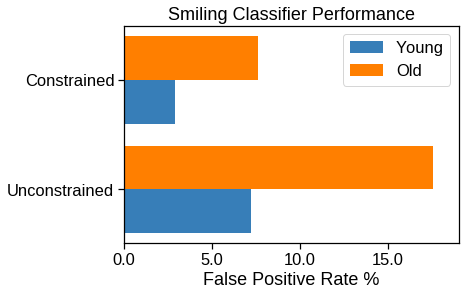

In [51]:
#@title Calculate FPR and Compare Constrained Performance
young_fpr_constrained = calculate_fpr(constrained_results_young)
old_fpr_constrained = calculate_fpr(constrained_results_old)

title = 'Smiling Classifier Performance'
fpr_results = [young_fpr_unconstrained, old_fpr_unconstrained,
               young_fpr_constrained, old_fpr_constrained]
plot_results(fpr_results, title)

With TFCO's ability to express a more complex requirement as a rate constraint, it helped this model achieve a more desirable outcome. Sure, there is still room for improvement, but at least TFCO was able to find the best performing model that satisfies the constraint (at least, with respect to the 'Young' group; the 'Old' Group is close to satisfying the constraint) while reducing the disparity between the groups as much as possible.